# Exercise 5: Lasso Regression on the Franke function  with resampling (Score 10 points))

This exercise is essentially a repeat of the previous two ones, but now
with Lasso regression. Write either your own code (difficult and optional) or, in this case,
you can also use the functionalities of **Scikit-Learn** (recommended). 
Give a
critical discussion of the three methods and a judgement of which
model fits the data best.  Perform here as well an analysis of the bias-variance trade-off using the **bootstrap** resampling technique and an analysis of the mean squared error using cross-validation. 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import resample
from sklearn.model_selection import  train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter



def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

def FrankeFunctionWithNoise(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    noise = np.random.normal(0, 0.1, len(x)*len(x))
    noise = noise.reshape(len(x),len(x))
    return term1 + term2 + term3 + term4 + noise


def create_X(x, y, n ):
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n+1)*(n+2)/2) # Number of elements in beta
    X = np.ones((N,l))

    for i in range(1,n+1):
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = (x**(i-k))*(y**k)
    return X

def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)



/Users/paulgiraud/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01835367294054624, tolerance: 0.008341379501628143
  model = cd_fast.enet_coordinate_descent(
/Users/paulgiraud/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010080040026512194, tolerance: 0.00692600582380276
  model = cd_fast.enet_coordinate_descent(
/Users/paulgiraud/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01166415434652901, tolerance: 0.007680863433465302
  model = cd_fast.enet_coordinate_descent(
/Users/paulgiraud/opt/anaconda3/lib/python3

Polynomial degree: 5
Log10(Lambda): -3.0
---------Bootstrap---------
Error: 0.020226561579837703
Bias^2: 0.019647412628896306
Var: 0.0005791489509413886
0.020226561579837703 >= 0.019647412628896306 + 0.0005791489509413886 = 0.020226561579837696
---------Cross Validation---------
Error_sklearn: 0.030043732656486643



Polynomial degree: 5
Log10(Lambda): -2.7241379310344827
---------Bootstrap---------
Error: 0.022975802861544492
Bias^2: 0.022529086543585215
Var: 0.00044671631795927485
0.022975802861544492 >= 0.022529086543585215 + 0.00044671631795927485 = 0.02297580286154449
---------Cross Validation---------
Error_sklearn: 0.04014046173175696



Polynomial degree: 5
Log10(Lambda): -2.4482758620689653
---------Bootstrap---------
Error: 0.03017446341127237
Bias^2: 0.029733396446411032
Var: 0.0004410669648613386
0.03017446341127237 >= 0.029733396446411032 + 0.0004410669648613386 = 0.03017446341127237
---------Cross Validation---------
Error_sklearn: 0.044715843060800835



Polynomial degre

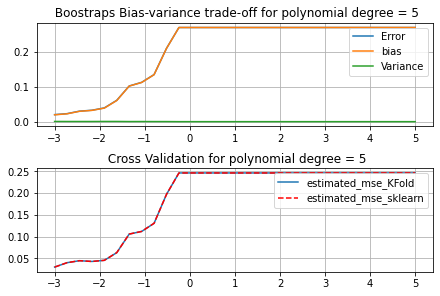

In [9]:
################# Parameters #################

n = 20  #number of data
list_degree = [5]
k = 10 #number of splits
n_bootstraps = 20
nlambdas = 30
lambdas = np.logspace(-3, 5, nlambdas)

#############################################

x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
x, y = np.meshgrid(x, y)
z = FrankeFunctionWithNoise(x, y)
z = z.ravel()


x_y = np.empty((len(x)*len(x), 2))
x_y[:, 0] = x.ravel()
x_y[:, 1] = y.ravel()
x_y_train, x_y_test, z_train, z_test = train_test_split(x_y, z.ravel(), test_size=0.2)


Error = np.empty((len(lambdas), len(list_degree)))

kfold = KFold(n_splits=k)


for degree in list_degree:

    scores_KFold = np.zeros((nlambdas, k))
    estimated_mse_sklearn = np.zeros(nlambdas)


    error = np.zeros(lambdas.shape[0])
    bias = np.zeros(lambdas.shape[0])
    variance = np.zeros(lambdas.shape[0])


    j = 0

    poly = PolynomialFeatures(degree=degree)
    
    for l in lambdas:

        lasso_bootstrap = Lasso(alpha=l, fit_intercept=False)
        lasso_cv = Lasso(alpha=l, fit_intercept=False)
        pred_test = np.empty((z_test.shape[0], n_bootstraps))
        pred_train = np.empty((z_train.shape[0], n_bootstraps))

        for i in range(n_bootstraps):
            
            x_y_, z_ = resample(x_y_train, z_train)
            X_train = poly.fit_transform(x_y_)
            lasso_bootstrap.fit(X_train, z_)
            Xtest = poly.fit_transform(x_y_test)
            pred_test[:, i] = lasso_bootstrap.predict(Xtest)


        z_pred_kfold  = np.empty((int(z.shape[0] / k), k))
        h = 0

        for train_index, test_index in kfold.split(x_y):
            x_train_kfold, x_test_kfold  = x_y[train_index], x_y[test_index]
            z_train_kfold, z_test_kfold = z[train_index], z[test_index]

            X_train = poly.fit_transform(x_train_kfold)
            lasso_cv.fit(X_train, z_train_kfold)
            Xtest = poly.fit_transform(x_test_kfold)
            zpred = lasso_cv.predict(Xtest)
            scores_KFold[j, h] = np.sum((zpred - z_test_kfold) ** 2) / np.size(zpred)
            z_pred_kfold[:, h] = zpred
            h += 1

        X = poly.fit_transform(x_y)
        
        estimated_mse_folds = cross_val_score(lasso_cv, X, z, scoring='neg_mean_squared_error',cv=kfold)
        estimated_mse_sklearn[j] = np.mean(-estimated_mse_folds)


        error[j] = np.mean(np.mean((z_test.reshape(z_test.shape[0], 1) - pred_test) ** 2, axis=1, keepdims=True))
        bias[j] = np.mean((z_test.reshape(z_test.shape[0], 1) - np.mean(pred_test, axis=1, keepdims=True)) ** 2)
        variance[j] = np.mean(np.var(pred_test, axis=1, keepdims=True))


        print('Polynomial degree:', degree)
        print('Log10(Lambda):',np.log10(l) )
        print("---------Bootstrap---------")
        print('Error:', error[j])
        print('Bias^2:', bias[j])
        print('Var:', variance[j])
        print('{} >= {} + {} = {}'.format(error[j], bias[j], variance[j], bias[j] + variance[j]))
        print("---------Cross Validation---------")
        print('Error_sklearn:', estimated_mse_sklearn[j])
        print("\n\n")

        j +=1

    fig, axs = plt.subplots(2, 1, constrained_layout=True)

    estimated_mse_KFold = np.mean(scores_KFold, axis=1)

    axs[0].plot(np.log10(lambdas), error, label='Error')
    axs[0].plot(np.log10(lambdas), bias, label='bias')
    axs[0].plot(np.log10(lambdas), variance, label='Variance')
    axs[0].set_title(" Boostraps Bias-variance trade-off for polynomial degree = " + str(degree))
    axs[0].legend()
    axs[0].grid()

    axs[1].plot(np.log10(lambdas), estimated_mse_KFold, label='estimated_mse_KFold')
    axs[1].plot(np.log10(lambdas), estimated_mse_sklearn,'r--',  label='estimated_mse_sklearn')
    axs[1].set_title(" Cross Validation for polynomial degree = " + str(degree))
    axs[1].legend()
    axs[1].grid()

plt.show()